In [169]:
from my_commonfunctions import *
from skimage.transform import probabilistic_hough_line

# Used functions

In [171]:
def get_rotation_angle(img):
    image = img
    edges = canny(image, 2, 1, 25)
    lines = probabilistic_hough_line(edges, threshold=50, line_length=50,
                                     line_gap=30)
    
    
    angles = []
    for i in range(50):
        p1,p2 = lines[i]
        angles.append(math.degrees(math.atan2(p2[1]-p1[1],p2[0]-p1[0])))
        if angles[i] < 0 :
            angles[i] = -1 * angles[i]
        if (angles[i] > 90):
            angles[i] = -1 * (180-angles[i])
    
    angle = np.median(np.array(angles))
    return angle

In [173]:
def rotate_bound(image, angle):
    (h, w) = image.shape[:2]
    (cX, cY) = (w / 2, h / 2)

    M = cv2.getRotationMatrix2D((cX, cY), -angle, 1.0)
    cos = np.abs(M[0, 0])
    sin = np.abs(M[0, 1])


    nW = int((h * sin) + (w * cos))
    nH = int((h * cos) + (w * sin))


    M[0, 2] += (nW / 2) - cX
    M[1, 2] += (nH / 2) - cY

    return cv2.warpAffine(image, M, (nW, nH),borderValue=(255,255,255))

In [175]:
def get_distance_between_staves(img_binary_bg_white):
    img_height = img_binary_bg_white.shape[0]
    
    flattened = img_binary_bg_white.T.flatten()
    flattened_indices = np.arange(0, flattened.shape[0], 1, np.uint32)
    flattened[flattened_indices % img_height == 0] = False # Separate each column with a black pixel
    
    image, contours, hierarchy = cv2.findContours((flattened*255).astype(np.uint8), 
                                              cv2.RETR_TREE, 
                                              cv2.CHAIN_APPROX_SIMPLE)
    
    # We refer to length as the vertical distance between 2 black pixels
    length_freq = np.zeros((img_height), dtype=np.uint32) # No contour can be taller than img_height because we separated each column with a black pixel
    all_possible_lengths = np.arange(0, img_height, 1, dtype=np.uint32)
    for i in contours:
        contour_y = i.T[1]
        length = contour_y[0][1] - contour_y[0][0] if len(contour_y[0]) == 2 else 1
        length_freq[length] += 1
    
    # plt.bar(all_possible_lengths, length_freq, width=3)
        
    return all_possible_lengths[length_freq == length_freq.max()][0]

# Read Image

In [309]:
test_gray = my_imread_gray('18.jpg')
print(np.max(test_gray)) # If this prints a float less than 1, multiply by 255 (as shown in the next line)
test_gray = (test_gray*255).astype(np.uint8)

0.807843137254902


# Fix Rotation

In [310]:
angle = get_rotation_angle(test_gray)
angle

-66.03067871222997

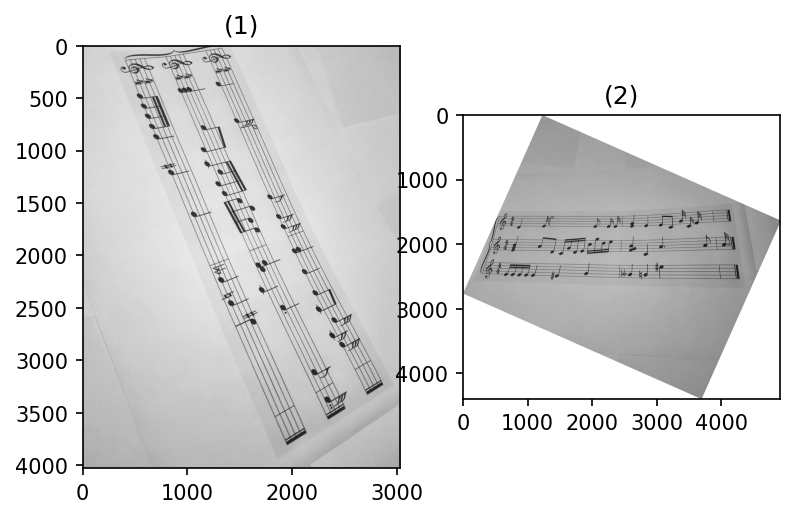

In [301]:
test_gray_rotated = rotate_bound(test_gray, angle)
my_show_images([test_gray, test_gray_rotated], dpi=150, row_max=2)

# Canny & Adaptive

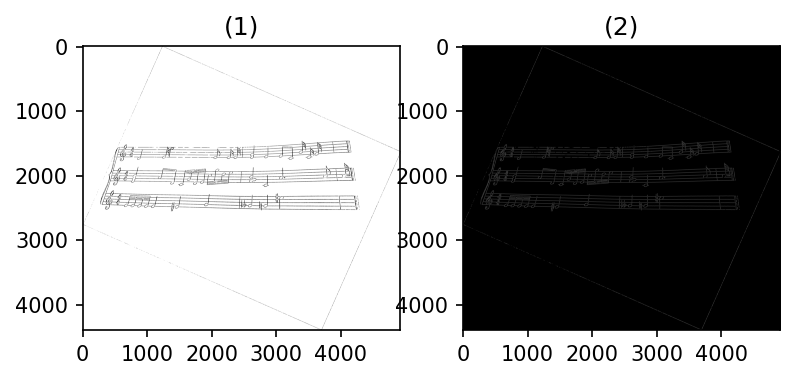

In [302]:
thresh = cv2.medianBlur(cv2.adaptiveThreshold(test_gray_rotated, 256, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 5), 7)
edges = cv2.Canny(thresh, 100, 200)


my_show_images([thresh, edges], dpi=150, row_max=2)

# Distance between staves -> Dilation -> Erosion -> Dilation

In [303]:
distance_between_staves = get_distance_between_staves(thresh)
kernel_size = distance_between_staves * 3
print(kernel_size)

k = np.ones((kernel_size, kernel_size))
k2 = np.ones((int(kernel_size*1.5), int(kernel_size*1.5)))
k3 = np.ones((kernel_size*6, kernel_size))
dilated = cv2.dilate(edges, k)
dilated_eroded = cv2.erode(dilated, k2)
dilated_eroded_dilated = cv2.dilate(dilated_eroded, k3)

108


# Contours

In [304]:
image, contours, hierarchy = cv2.findContours(dilated_eroded_dilated, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
dilated_eroded_dilated_contours = cv2.drawContours(cv2.cvtColor((dilated_eroded_dilated*255).astype(np.uint8), cv2.COLOR_GRAY2RGB), contours, -1, (0,255,0), 3)
len(contours)

5

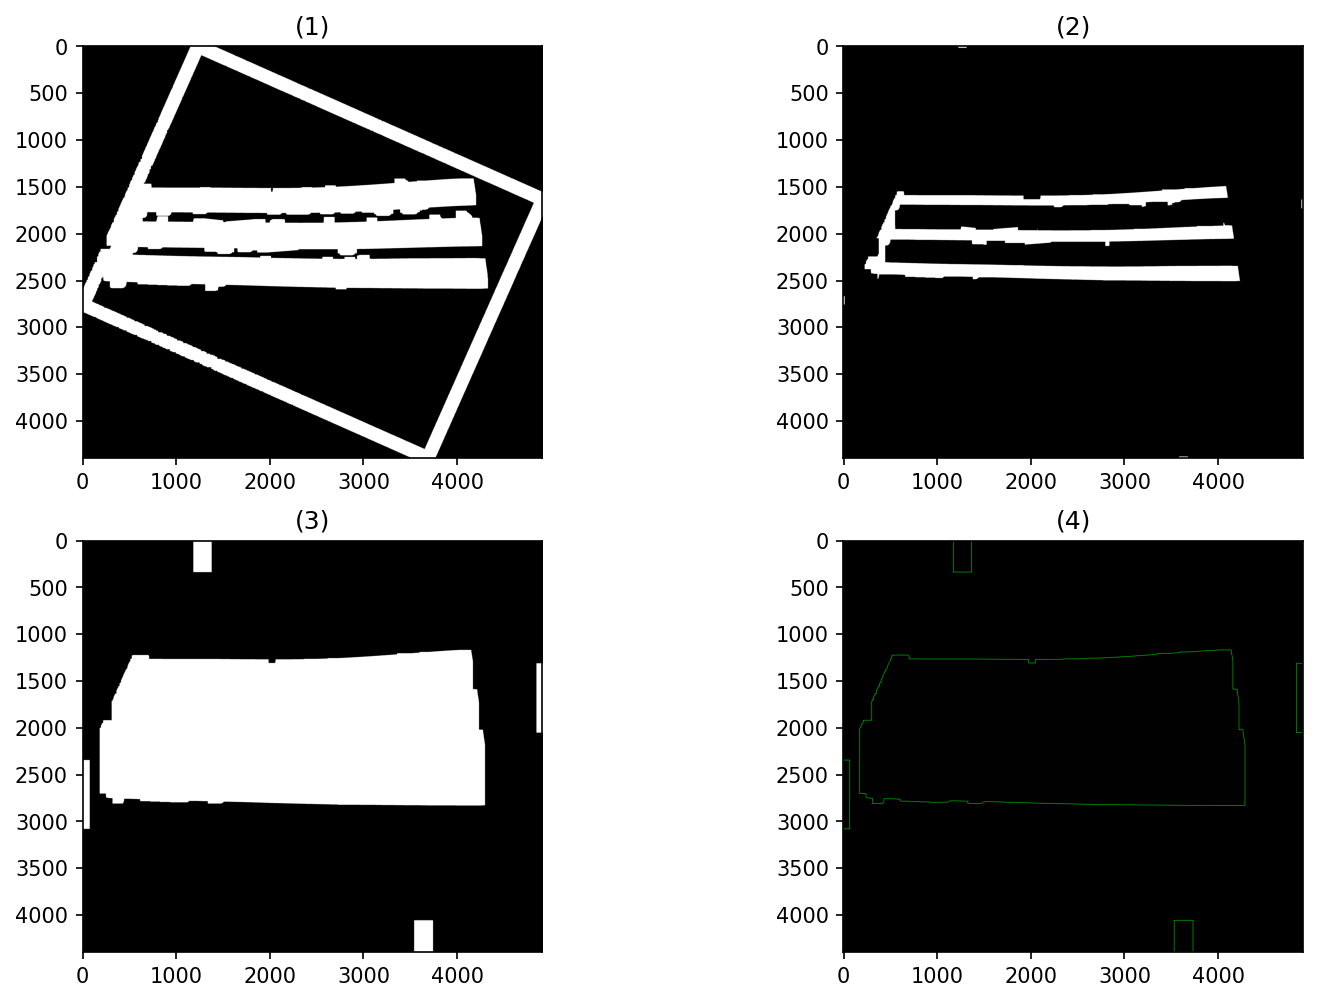

In [305]:
my_show_images([dilated, dilated_eroded, dilated_eroded_dilated, dilated_eroded_dilated_contours], dpi=150, row_max=2)

# Get the contour with the maximum area

In [312]:
i = 0
i_max = 0
area_max = 0
for c in contours:
    area = cv2.contourArea(c)
    if area > area_max:
        area_max = area
        i_max = i
    i += 1

i_max

3

In [314]:
# U can use this as a metric
# U can use this as a metric
# U can use this as a metric
# U can use this as a metric
# U can use this as a metric
# U can use this as a metric
# U can use this as a metric
# U can use this as a metric
# U can use this as a metric
# U can use this as a metric
# U can use this as a metric

# The bounding box of the maximum area contour

x, y, w, h = cv2.boundingRect(contours[i_max])
x, y, w, h

(178, 1173, 4115, 1662)

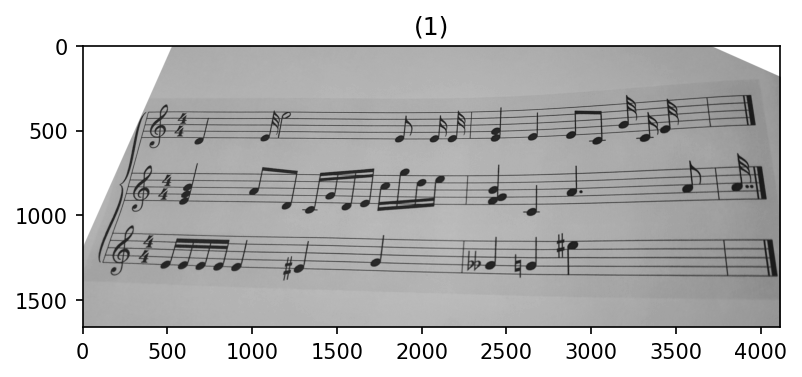

In [308]:
test_rotated_croped = test_gray_rotated[y:y+h, x:x+w]
my_show_images([test_rotated_croped], dpi=150, row_max=1)